## X-Forum, Projet de MAP

In [1]:
#un truc joli pour voir combien de temps marche une cycle
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display
    from datetime import timedelta
    from time import time
    
    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)
    
    index = 0
    timestamps = []
    delta_timestamps = []
    try:
        for index, record in enumerate(sequence, 1):
            timestamps.append(time())
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    if len(timestamps) == 1 :
                        eta = u''
                    else:
                        delta_timestamps.append(timestamps[-1] - timestamps[-2])
                        last = timedelta(seconds=timestamps[-1] - timestamps[-2])
                        avr = sum(delta_timestamps) / float(len(delta_timestamps))
                        eta = u'(time remaining : {eta} | last : {last} | avr : {avr})'.format(
                            eta=str(timedelta(seconds=avr * (size - index))).split('.', 2)[0],
                            last=str(last).split('.', 2)[0],
                            avr=str(timedelta(seconds=avr)).split('.', 2)[0]
                        )
                    label.value = u'{index} / {size} {eta}'.format(
                        index=index,
                        size=size,
                        eta=eta
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        try:
            avr = u' | avr iteration time : {avr})'.format(
                avr=str(timedelta(seconds=sum(delta_timestamps)
                                  / float(len(delta_timestamps)))).split('.', 2)[0]
            )
        except:
            avr=')'
        try:
            total = u' (total time : {total}'.format(
                total=str(timedelta(seconds=timestamps[-1]-timestamps[0])).split('.', 2)[0]
            )
        except:
            avr = ''
            total = ''
        label.value = str(str(index) + total + avr or '?')

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import Counter
from numpy import cumsum
from scipy import stats
from scipy.stats import norm

In [6]:
#take one random goodie from 2 boxes (first strategy)
def choose_a_goodie_first_st(L, n): #L - list of n elements, n - number of colors
    i = random.randint(0, n-1)
    while L[i] == 0:
        i = random.randint(0, n-1)
    L[i] -= 1
    return L
    
#take one random goodie from 1 box (second strategy)
def choose_a_goodie_second_st(L, n): #L - list of n elements, n - number of colors
    all_goodies = np.sum(L)
    p = list(1.0*L / all_goodies) #probability of taking from i-th box is L[i] / all_goodies
    #i = np.random.choice(n, 1, p)[0] apparently it doesn't work properly
    custm = stats.rv_discrete(name='custm', values=(np.arange(n), p))
    i = custm.rvs(size=1)
    L[i] -= 1
    return L

#take one random goodie from 1 box (second strategy)
#WORKS MUCH MORE FASTER but code is not that nice 
def choose_a_goodie_second_st_beta(L, n): #L - list of n elements, n - number of colors
    all_goodies = np.sum(L)
    p = np.array(1.0*L / all_goodies) #probability of taking from i-th box is L[i] / all_goodies
    cumsum = np.cumsum(p)
    r = random.random()
    i = next(j for j, v in enumerate(cumsum) if r < v)
    L[i] -= 1
    return L

#take one random goodie from 1 box with 2 colors (second strategy)
#it's very good for 2 colors, but actually it's just a subcase of choose_a_goodie_second_st_beta
def choose_a_goodie_second_st2(L): #L - list of two elements, first 
    p = 1.0*L[0]/(L[0]+L[1]) # probability of taking read goodie
    i = np.random.binomial(1, p) #i = 1 with proba p et i = 0 with proba 1-p
    if i == 0:
        return [L[0], L[1]-1]
    else:
        return [L[0]-1, L[1]]

def choose_a_goodie(L, n, s): # L - list of n elements, n - number of colors, s - strategy (1 or 2)
    if s == 1:
        return choose_a_goodie_first_st(L, n)
    if s == 2:
        if (n > 2):
            return choose_a_goodie_second_st_beta(L, n)
        if (n == 2):
            return choose_a_goodie_second_st2(L)

In [7]:
#n - number of colors, N - number of goodies of each color, s - strategy (1 or 2)
#return one realisation of chosen random variable
def generate_random_variable(n, N, s):
    boxes = N*np.ones(n, dtype=np.int)
    variable = 0
    #taking goodies while there are in both boxes
    count = N #counter of non empty boxes
    while count > 1:
        boxes = choose_a_goodie(boxes, n, s)
        count = sum(box > 0 for box in boxes)
    variable = np.sum(boxes)
    return variable

#n - number of colors, N - number of goodies of each color, k - number of simulations, s - strategy (1 or 2)
#returns array of realisations of chosen random variable
def make_simulations(n, N, k, s):
    variables = np.zeros(k) #number of goodies left at the end
    #for i in range(k): #i - index of the simulation
    for i in log_progress(range(k)):
        variables[i] = generate_random_variable(n, N, s)
    return variables

#!!!counts empirical probabilities by given sample with addinig missing values; variables must be an array of int
def values_and_empirical_probabilities(variables):
    c = Counter(variables)
    k = len(variables)
    max_number_of_goodies_left = int(max(c.keys()))
    all_possible_numbers_of_goodies_left = range(1, 1 + max_number_of_goodies_left)
    res = np.zeros(max_number_of_goodies_left + 1)

    for i in all_possible_numbers_of_goodies_left:
        res[i] = c[i]
    probability = (1.0/k)*np.array(res[1:max_number_of_goodies_left + 1])
    
    return (np.array(all_possible_numbers_of_goodies_left), probability)

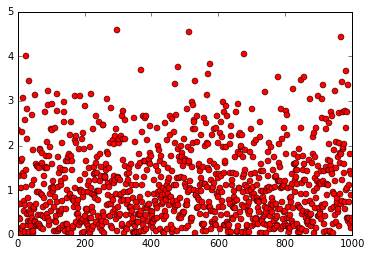

In [13]:
n = 2 #number of colors
N = 1000 #number of goodies of each color
k = 1000 #number of simulations
s = 1 # strategy
coefficient = 1
if s == 1:
    coefficient = 1.0/math.sqrt(N)

variables = make_simulations(n, N, k, s)
plt.plot(np.arange(k), coefficient*variables, 'ro')

<Container object of 145 artists>

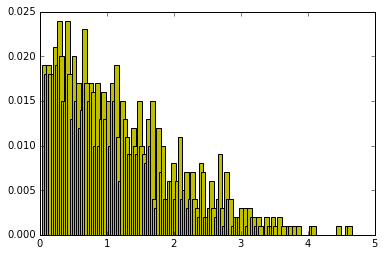

In [14]:
all_possible_numbers_of_goodies_left, probability = values_and_empirical_probabilities(variables)

width = 1
if s == 1:
    width = 10.0/len(all_possible_numbers_of_goodies_left)

plt.bar(coefficient*all_possible_numbers_of_goodies_left, probability, width=width, color='y')

<Container object of 145 artists>

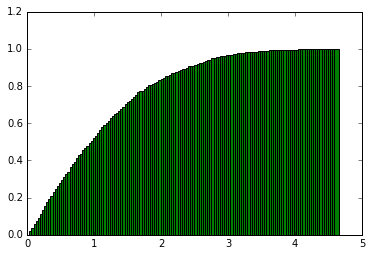

In [15]:
CDF = np.cumsum(probability) #cumulative distribution function
plt.bar(coefficient*all_possible_numbers_of_goodies_left, CDF, width=width, color='g')

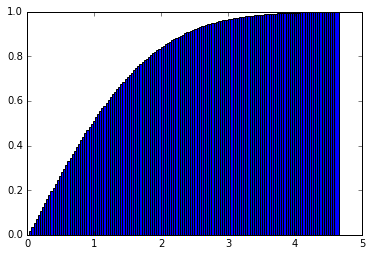

In [16]:
#attention - it's only for s = 1 (almost gauss)
if (s == 1):
    sigma = math.sqrt(1.0*n/(n-1))
    plt.bar(coefficient*all_possible_numbers_of_goodies_left, 2*norm.cdf(coefficient*all_possible_numbers_of_goodies_left, 0, sigma)-1, width=width, color='b')
if (s == 2):
    print 'Obviously it is geometric!'

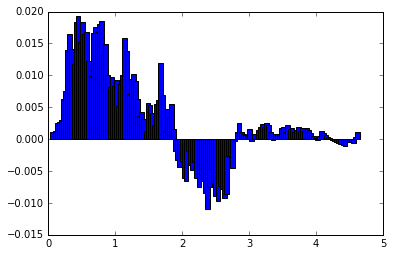

In [17]:
if (s == 1):
    plt.bar(coefficient*all_possible_numbers_of_goodies_left, CDF - (2*norm.cdf(coefficient*all_possible_numbers_of_goodies_left, 0, sigma)-1), width=width, color='b')

In [13]:
sum_of_variables = coefficient*sum(variables)
expectation = sum_of_variables / k
print expectation

1.515
